In [ ]:
# !wget -P /content/drive/MyDrive/Colab_Notebooks/Martian_HiRISE_dataset http://dataverse.jpl.nasa.gov/api/access/datafile/83039

In [ ]:
# !unzip drive/MyDrive/Colab_Notebooks/Martian_HiRISE_dataset/clean_dataset.zip -d drive/MyDrive/Colab_Notebooks/Martian_HiRISE_dataset/

# Import Package

In [5]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
from numba import cuda
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Exploration and Pre-processing
This section is partially processed on my local computer, I modified the dataset structue based on given txt files and make them three different dataset folder(train, test, val and the two classes folders under them).

In [7]:
folder_dict = './drive/MyDrive/Colab_Notebooks/Martian_HiRISE_dataset/'
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 5
SEED = 17

# Head directory containing all image subframes
train_head_dir = Path(folder_dict + 'clean_dataset/train')
test_head_dir = Path(folder_dict + 'clean_dataset/test')
val_head_dir = Path(folder_dict + 'clean_dataset/val')


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_head_dir, image_size=IMAGE_SIZE, seed=SEED, batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_head_dir, image_size=IMAGE_SIZE, seed=SEED, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(val_head_dir, image_size=IMAGE_SIZE, seed=SEED, batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 28134 files belonging to 2 classes.
Found 12823 files belonging to 2 classes.
Found 11286 files belonging to 2 classes.
['background', 'frost']


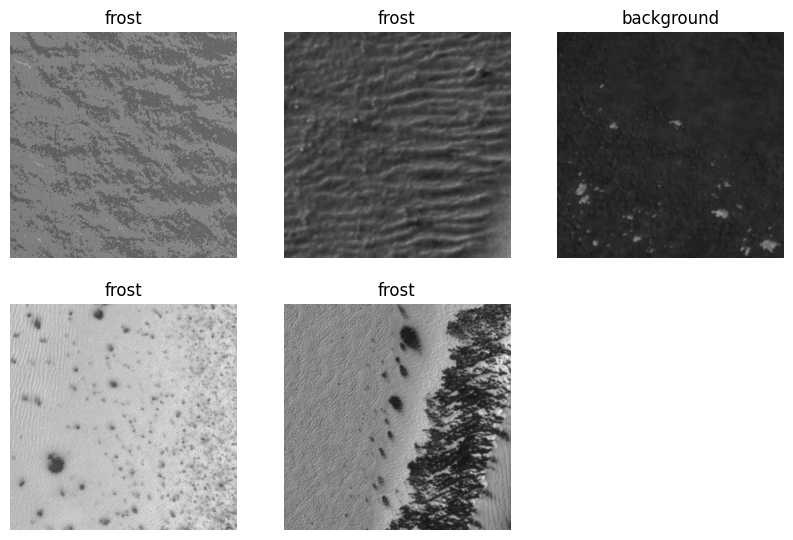

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # Adjust the range based on the size of the batch
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(5, 299, 299, 3)
(5,)


## Data augmentation

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomCrop(height=299, width=299),  # Adjust the size as needed
    layers.RandomContrast(factor=0.3),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.Rescaling(1./255, input_shape=(299, 299, 3))
], name="data_augmentation")

# Training CNN + MLP

## Training

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  # First convolutional layer
  Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3), padding='same', kernel_regularizer=l2(0.001)),
  BatchNormalization(),
  Dropout(0.3),

  # Second convolutional layer
  Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
  BatchNormalization(),
  Dropout(0.3),

  # Third convolutional layer
  Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
  BatchNormalization(),
  Dropout(0.3),

  # Flatten layer to feed into the dense layer
  Flatten(),

  # Dense layer (MLP)
  Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
  BatchNormalization(),
  Dropout(0.3),

  # Output layer with sigmoid activation
  Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 299, 299, 16)      64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 299, 299, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 299, 299, 32)      128       
 chNormalization)                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


880/880 [==============================] - 207s 225ms/step - loss: 3.7007 - accuracy: 0.6820 - precision: 0.7116 - recall: 0.7353 - val_loss: 1.1605 - val_accuracy: 0.8228 - val_precision: 0.7169 - val_recall: 0.7426
Epoch 2/20
880/880 [==============================] - 178s 202ms/step - loss: 1.2103 - accuracy: 0.7233 - precision: 0.7400 - recall: 0.7867 - val_loss: 1.2010 - val_accuracy: 0.6272 - val_precision: 0.4624 - val_recall: 0.9727
Epoch 3/20
880/880 [==============================] - 178s 202ms/step - loss: 1.3407 - accuracy: 0.7448 - precision: 0.7557 - recall: 0.8102 - val_loss: 1.5162 - val_accuracy: 0.7383 - val_precision: 0.5624 - val_recall: 0.8420
Epoch 4/20
880/880 [==============================] - 178s 202ms/step - loss: 1.8723 - accuracy: 0.7632 - precision: 0.7706 - recall: 0.8271 - val_loss: 2.8777 - val_accuracy: 0.7598 - val_precision: 0.9946 - val_recall: 0.2550
Epoch 5/20
880/880 [==============================] - 179s 203ms/step - loss: 2.6429 - accuracy: 0.

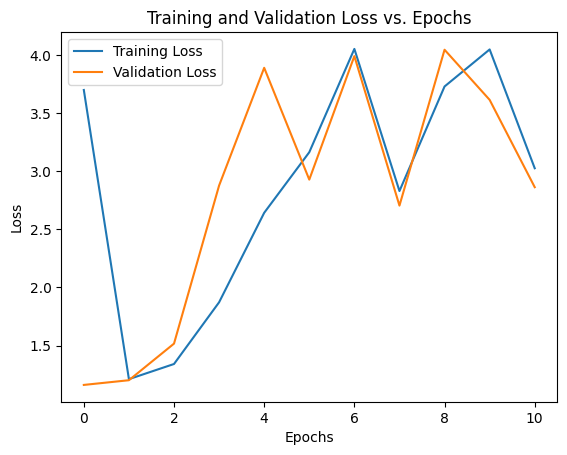

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Plot training and validation errors vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Result

In [ ]:
# Evaluate the model on the validation set
results = model.evaluate(val_ds, verbose=0)

# Retrieve the precision and recall values
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

Precision: 0.7169058918952942
Recall: 0.7425661087036133
F1 Score: 0.7295104232666707


In [ ]:
# device = cuda.get_current_device()
# device.reset()

**Restart session on Google Colab if the memory is not free**

# Transfer Learning

## EfficentNetB0

In [ ]:
# Define the input layer
input = Input(shape=(299, 299, 3))

# Apply data augmentation to the inputs
x = data_augmentation(input)

# Load the pre-trained model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the layers of the base model

# Add new classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)  # ReLU activation function in the last layer
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Combine the base model and the new classifier layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()


16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 299, 299, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     

Epoch 1/20
5626/5627 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8600 - precision: 0.8746 - recall: 0.8781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5627/5627 [==============================] - 131s 21ms/step - loss: 0.3261 - accuracy: 0.8599 - precision: 0.8746 - recall: 0.8780 - val_loss: 0.2621 - val_accuracy: 0.8734 - val_precision: 0.7296 - val_recall: 0.9637
Epoch 2/20
5627/5627 [==============================] - 118s 21ms/step - loss: 0.2786 - accuracy: 0.8848 - precision: 0.8960 - recall: 0.9007 - val_loss: 0.2558 - val_accuracy: 0.8801 - val_precision: 0.7391 - val_recall: 0.9697
Epoch 3/20
5627/5627 [==============================] - 117s 21ms/step - loss: 0.2705 - accuracy: 0.8907 - precision: 0.9002 - recall: 0.9072 - val_loss: 0.2185 - val_accuracy: 0.9028 - val_precision: 0.7900 - val_recall: 0.9507
Epoch 4/20
5627/5627 [==============================] - 118s 21ms/step - loss: 0.2524 - accuracy: 0.8986 - precision: 0.9081 - recall: 0.9128 - val_loss: 0.2726 - val_accuracy: 0.8769 - val_precision: 0.7341 - val_recall: 0.9683
Epoch 5/20
5627/5627 [==============================] - 119s 21ms/step - loss: 0.2453 - accurac

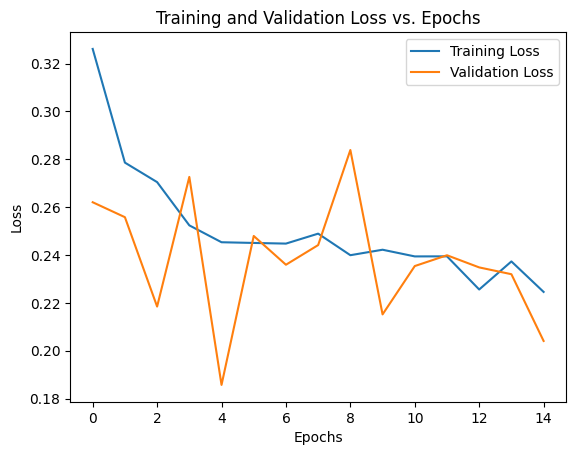

In [ ]:
# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Plot training and validation errors vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
results = model.evaluate(val_ds, verbose=0)

# Retrieve the precision and recall values
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f'EfficentNetB0 Precision: {precision}')
print(f'EfficentNetB0 Recall: {recall}')
print(f'EfficentNetB0 F1 Score: {f1_score}')

EfficentNetB0 Precision: 0.802820086479187
EfficentNetB0 Recall: 0.9719163179397583
EfficentNetB0 F1 Score: 0.8793124888587543


## ResNet50

In [13]:
# Define the input layer
input = Input(shape=(299, 299, 3))

# Apply data augmentation to the inputs
x = data_augmentation(input)

# Load the pre-trained model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the layers of the base model

# Add new classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)  # ReLU activation function in the last layer
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Combine the base model and the new classifier layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                         

Epoch 1/20
5627/5627 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8849 - precision: 0.8994 - recall: 0.8966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5627/5627 [==============================] - 2254s 398ms/step - loss: 0.2840 - accuracy: 0.8849 - precision: 0.8994 - recall: 0.8966 - val_loss: 0.4584 - val_accuracy: 0.8573 - val_precision: 0.6964 - val_recall: 0.9865
Epoch 2/20
5627/5627 [==============================] - 138s 25ms/step - loss: 0.2350 - accuracy: 0.9081 - precision: 0.9168 - recall: 0.9209 - val_loss: 0.4052 - val_accuracy: 0.8576 - val_precision: 0.7012 - val_recall: 0.9716
Epoch 3/20
5627/5627 [==============================] - 137s 24ms/step - loss: 0.2301 - accuracy: 0.9115 - precision: 0.9193 - recall: 0.9246 - val_loss: 0.3809 - val_accuracy: 0.8695 - val_precision: 0.7142 - val_recall: 0.9909
Epoch 4/20
5627/5627 [==============================] - 136s 24ms/step - loss: 0.2071 - accuracy: 0.9195 - precision: 0.9271 - recall: 0.9306 - val_loss: 0.3942 - val_accuracy: 0.8630 - val_precision: 0.7028 - val_recall: 0.9953
Epoch 5/20
5627/5627 [==============================] - 136s 24ms/step - loss: 0.2062 - accur

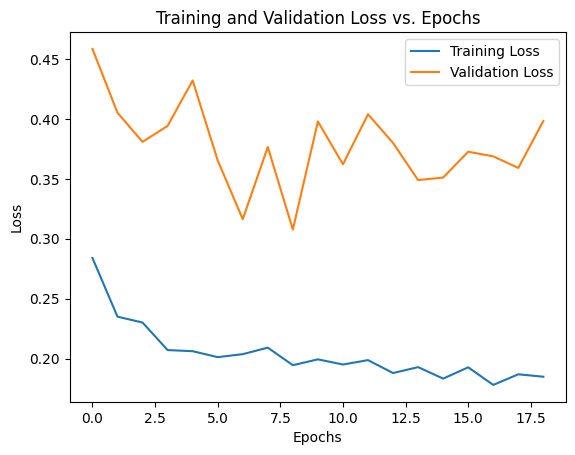

ResNet50 Precision: 0.7374026775360107
ResNet50 Recall: 0.9911894202232361
ResNet50 F1 Score: 0.845665942087141


In [15]:
# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Plot training and validation errors vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the validation set
results = model.evaluate(val_ds, verbose=0)

# Retrieve the precision and recall values
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f'ResNet50 Precision: {precision}')
print(f'ResNet50 Recall: {recall}')
print(f'ResNet50 F1 Score: {f1_score}')

## VGG16

In [16]:
# Define the input layer
input = Input(shape=(299, 299, 3))

# Apply data augmentation to the inputs
x = data_augmentation(input)

# Load the pre-trained model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the layers of the base model

# Add new classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)  # ReLU activation function in the last layer
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Combine the base model and the new classifier layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                            

Epoch 1/20
5627/5627 [==============================] - 169s 30ms/step - loss: 0.3579 - accuracy: 0.8453 - precision: 0.8612 - recall: 0.8659 - val_loss: 0.4356 - val_accuracy: 0.7880 - val_precision: 0.6082 - val_recall: 0.9590
Epoch 2/20
5627/5627 [==============================] - 166s 30ms/step - loss: 0.3191 - accuracy: 0.8659 - precision: 0.8797 - recall: 0.8835 - val_loss: 0.3675 - val_accuracy: 0.8145 - val_precision: 0.6443 - val_recall: 0.9460
Epoch 3/20
5627/5627 [==============================] - 168s 30ms/step - loss: 0.3058 - accuracy: 0.8735 - precision: 0.8865 - recall: 0.8902 - val_loss: 0.3206 - val_accuracy: 0.8640 - val_precision: 0.7172 - val_recall: 0.9532
Epoch 4/20
5627/5627 [==============================] - 167s 30ms/step - loss: 0.3044 - accuracy: 0.8745 - precision: 0.8872 - recall: 0.8913 - val_loss: 0.3714 - val_accuracy: 0.8133 - val_precision: 0.6388 - val_recall: 0.9664
Epoch 5/20
5627/5627 [==============================] - 167s 30ms/step - loss: 0.300

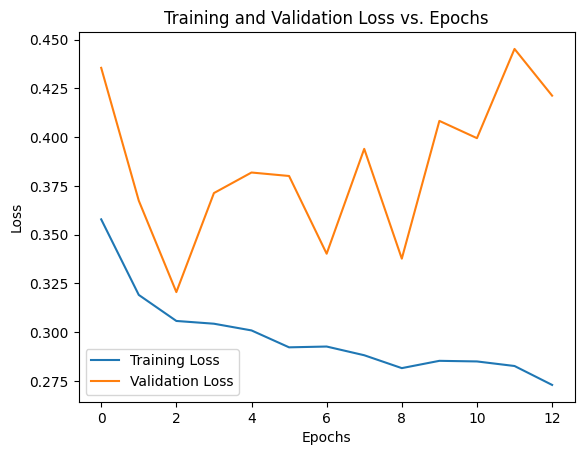

VGG16 Precision: 0.7172156572341919
VGG16 Recall: 0.9531938433647156
VGG16 F1 Score: 0.8185364709615169


In [17]:
# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Plot training and validation errors vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the validation set
results = model.evaluate(val_ds, verbose=0)

# Retrieve the precision and recall values
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f'VGG16 Precision: {precision}')
print(f'VGG16 Recall: {recall}')
print(f'VGG16 F1 Score: {f1_score}')

# Compare the results of transfer learning with those of CNN + MLP model

F1 scores: CNN+MLP = 72.9 %, EfficentNetB0 = 87.9, ResNet50 = 84.5%, VGG16 = 81.8% <br>
Apparentlly transfer learning got a better result, due to the huge training data of ImageNet. The pre-trained model help us to get a more robust and useful freature from the input images.